<a href="https://colab.research.google.com/github/sepehrX12/Intrinsic-Alignment-Project/blob/main/CCL_LSST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [58]:
import sys
sys.path.append('/content/Intrinsic-Alignment-Project')
import srd_redshift_distributions

In [80]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from srd_redshift_distributions import SRDRedshiftDistributions
from binning import Binning

In [60]:
# Create new Cosmology object with a given set of parameters. This keeps track
# of previously-computed cosmological functions
cosmo = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96,
    transfer_function='bbks')

# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0., 1., 500)
n = np.ones(z_n.shape)

# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
ell = np.arange(2, 10)
cls = cosmo.angular_cl(lens1, lens2, ell)
print(cls)

[8.68063555e-09 1.17960668e-08 1.30533061e-08 1.35122646e-08
 1.35757834e-08 1.34276819e-08 1.31622980e-08 1.28319517e-08]


In [74]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.0, 3.5, 500)
forecast_years = ["1", "10"]  # LSST forecasting epochs

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = SRDRedshiftDistributions(redshift_range,
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = SRDRedshiftDistributions(redshift_range,
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
print(redshift_distribution["sources"].keys())

dict_keys(['1', '10'])


In [75]:
# Set global line width and font sizes
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15

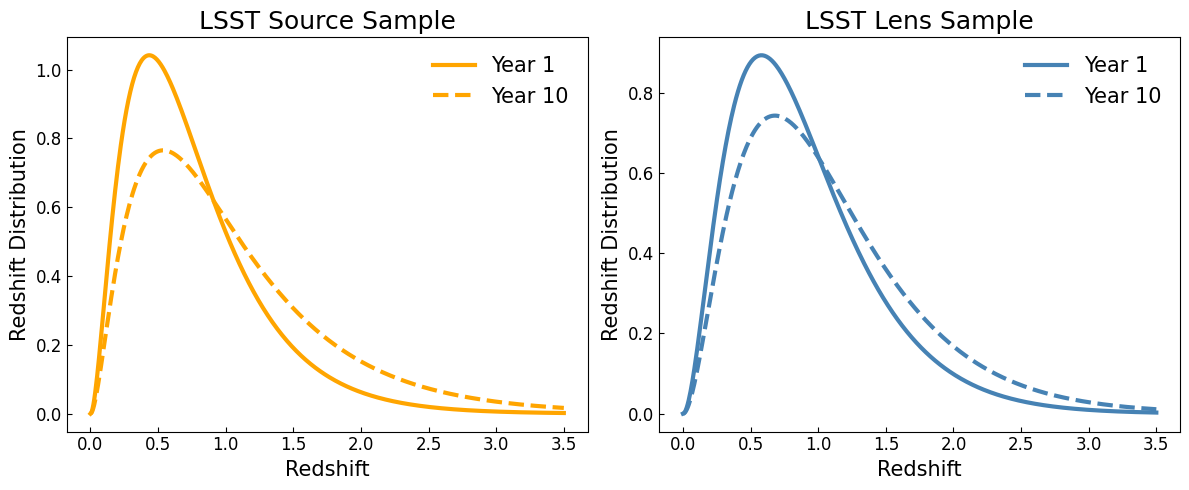

In [76]:
# Define the colors and sample types
colors = {'sources': 'orange',
          'lenses': 'steelblue'}
sample_types = ['sources', 'lenses']
titles = {'sources': 'LSST Source Sample',
          'lenses': 'LSST Lens Sample'}

# Create 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loop through sample types to create the plots
for ax, sample_type in zip(axs, sample_types):
    ax.plot(redshift_range, redshift_distribution[sample_type]['1'], label='Year 1', linestyle='-', color=colors[sample_type])
    ax.plot(redshift_range, redshift_distribution[sample_type]['10'], label='Year 10', linestyle='--', color=colors[sample_type])
    ax.set_title(titles[sample_type])
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Redshift Distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

In [81]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = Binning(redshift_range,
                                    redshift_distribution["sources"][year],
                                    year).source_bins(normalised=True,
                                                      save_file=False)
    bins["lenses"][year] = Binning(redshift_range,
                                   redshift_distribution["lenses"][year],
                                   year).lens_bins(normalised=True,
                                                   save_file=False)

In [82]:
# Define colors for plots
lens_colors = {
    "1": cmr.take_cmap_colors('cmr.freeze',
                              len(bins["lenses"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.freeze', len(bins["lenses"]["10"]), cmap_range=(0.2, 0.85), return_fmt='hex')
}

source_colors = {
    "1": cmr.take_cmap_colors('cmr.ember',
                              len(bins["sources"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.ember',
                               len(bins["sources"]["10"]),
                               cmap_range=(0.2, 0.85),
                               return_fmt='hex')
}

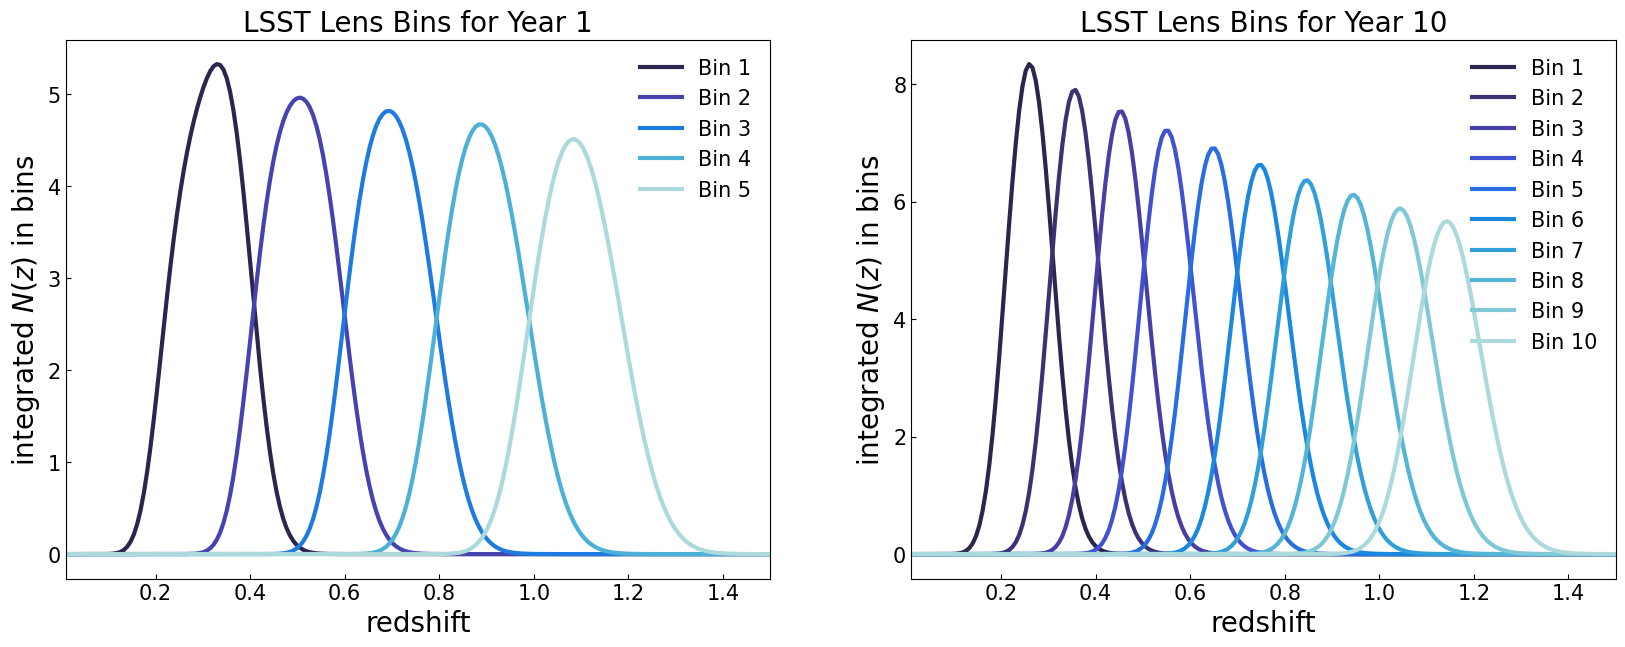

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=lens_colors[year][bin_idx])
        ax.set_xlim(0.01, 1.5)
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

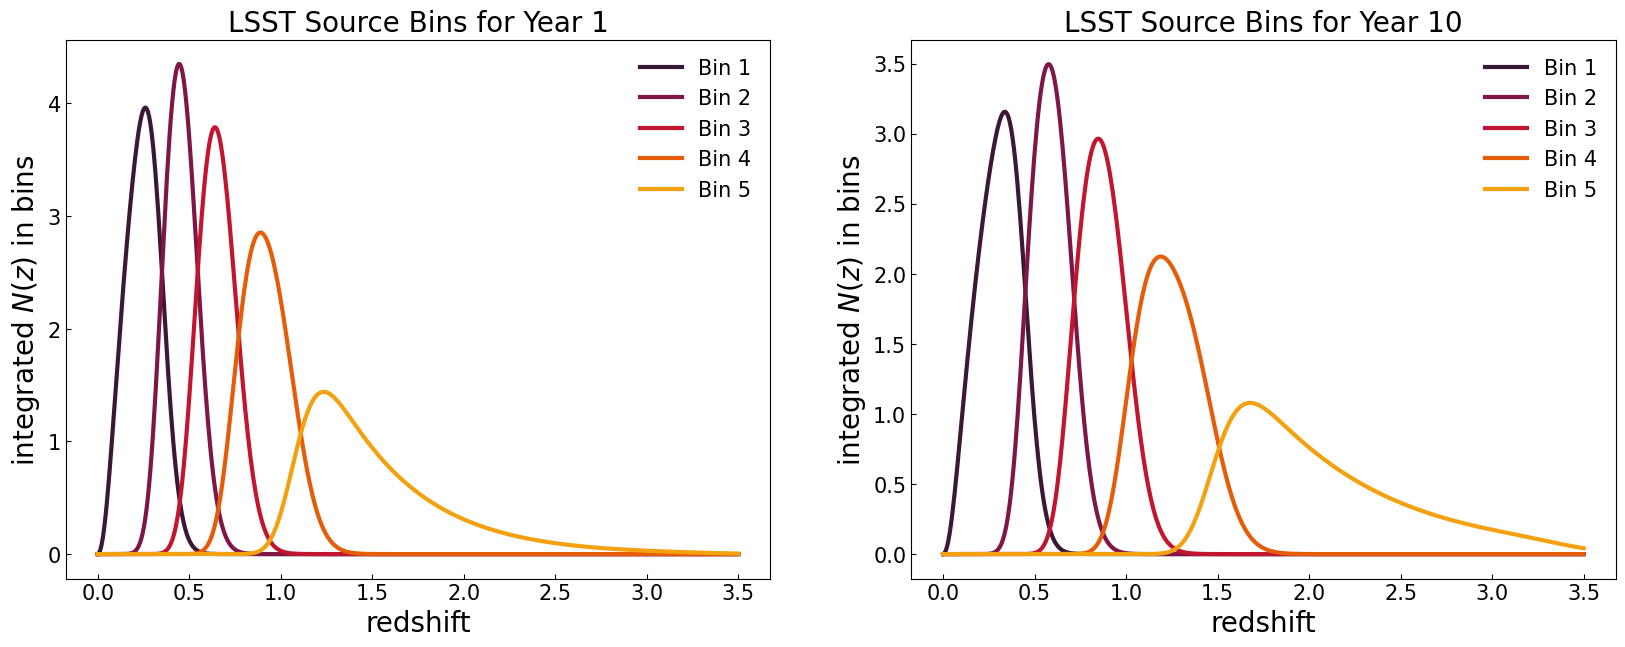

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=source_colors[year][bin_idx])
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

In [86]:
bin_centers_y1 = Binning(redshift_range,
                         redshift_distribution["sources"]["1"],
                         "1").get_bin_centers(save_file=False, decimal_places=2)

bin_centers_y10 = Binning(redshift_range,
                          redshift_distribution["sources"]["10"],
                          "10").get_bin_centers(save_file=False, decimal_places=2)

print(bin_centers_y1.keys())
print(bin_centers_y10.keys())
print(f"bin centers for sources year 1: {bin_centers_y1['sources']}, \n bin centers for lenses year 1: {bin_centers_y1['lenses']}")
print(f"bin centers for sources year 10: {bin_centers_y10['sources']}, \n bin centers for lenses year 10: {bin_centers_y10['lenses']}")

dict_keys(['sources', 'lenses'])
dict_keys(['sources', 'lenses'])
bin centers for sources year 1: [0.26, 0.44, 0.64, 0.89, 1.23], 
 bin centers for lenses year 1: [0.32, 0.49, 0.69, 0.88, 1.08]
bin centers for sources year 10: [0.34, 0.58, 0.85, 1.19, 1.68], 
 bin centers for lenses year 10: [0.26, 0.35, 0.45, 0.55, 0.65, 0.74, 0.84, 0.95, 1.05, 1.14]


Now to calculate 2 point correlation functions for the cosmology.